In [1]:
from IPython.display import display

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error

register_matplotlib_converters()

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from numpy import log
from time import time
import seaborn as sns
sns.set_theme(style="whitegrid")
import itertools
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = np.random.seed(0)

In [2]:
df = pd.read_csv('data/Max.csv')
df = df[['time_stamp', 'value']]
df['time_stamp'] = pd.to_datetime(df['time_stamp'])


In [3]:

# # Convert the 'time_stamp' column to datetime, remove the timezone information, and floor to the nearest hour
# df['time_stamp'] = pd.to_datetime(df['time_stamp']).dt.tz_localize(None).dt.floor('H')

# # Adjust the start hour to 16 if it should start from hour 16
# df['time_stamp'] = df['time_stamp'] + pd.DateOffset(hours=16)

# # Sort the dataframe by time_stamp to maintain chronological order
# df = df.sort_values(by='time_stamp').reset_index(drop=True)

# # Remove duplicates, keeping the first occurrence of each hour in a 24-hour period
# df['date'] = df['time_stamp'].dt.date
# df['hour'] = df['time_stamp'].dt.hour
# df = df.drop_duplicates(subset=['date', 'hour'])

# # Drop the auxiliary columns
# df.drop(columns=['date', 'hour'], inplace=True)

# # Format the time_stamps to the desired format
# df['time_stamp'] = df['time_stamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
# df.to_csv('data/Max.csv', index=False)

In [4]:
df = df.groupby('time_stamp')['value'].sum()

In [6]:
df.head()

time_stamp
2024-06-17 10:00:00    2.387710e+06
2024-06-17 11:00:00    6.210716e+09
2024-06-17 12:00:00    5.858394e+09
2024-06-17 13:00:00    0.000000e+00
2024-06-17 14:00:00    0.000000e+00
Name: value, dtype: float64

Text(0, 0.5, '% CPU Usage')

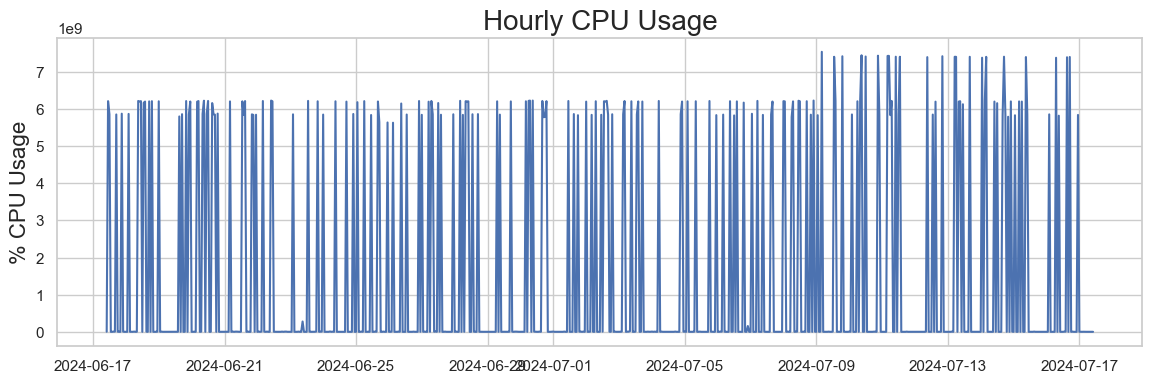

In [7]:
#plot
plt.figure(figsize=(14,4))
plt.plot(df)
plt.title('Hourly CPU Usage', fontsize=20)
plt.ylabel('% CPU Usage', fontsize=16)


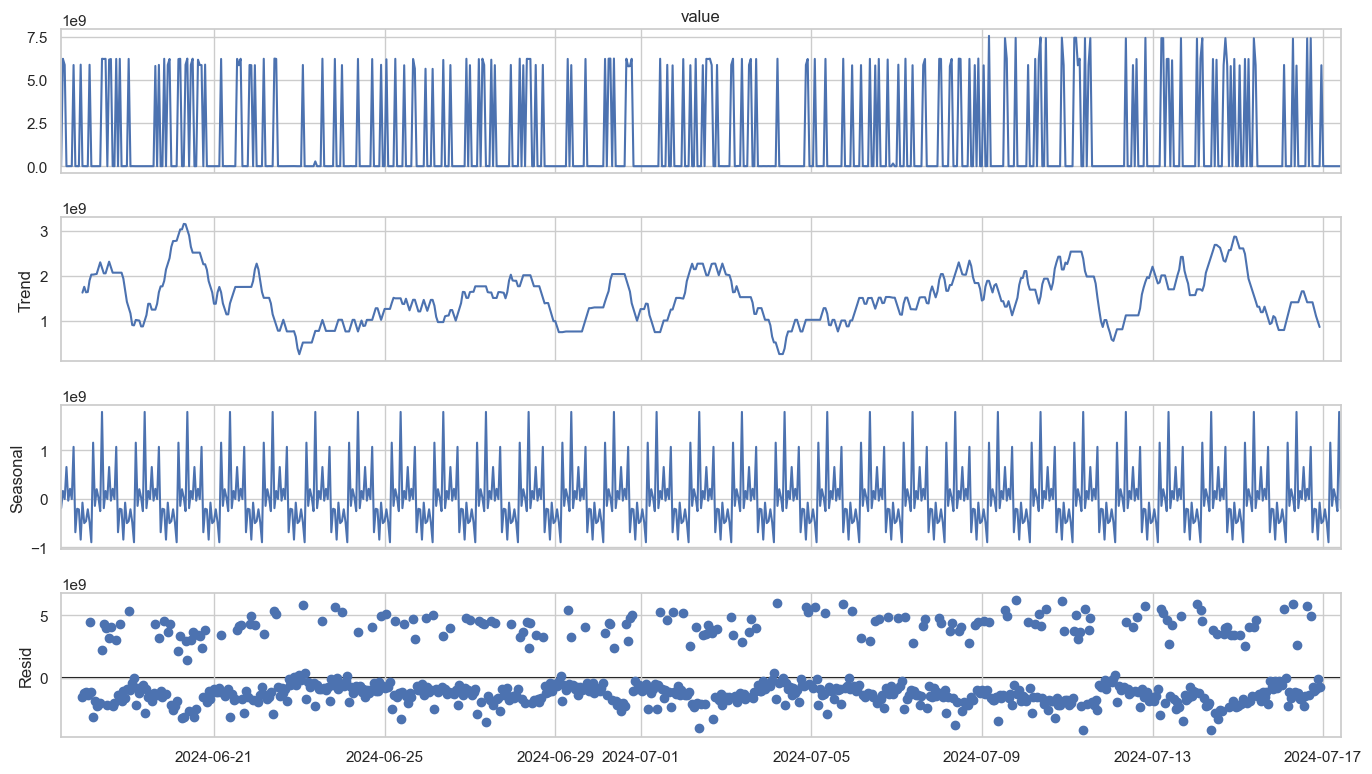

In [8]:
#STL (Seasonal Trend) Decomposition
plt.rc('figure',figsize=(14,8))
plt.rc('font',size=15)

result_stl = seasonal_decompose(df,model='additive')
fig = result_stl.plot()

In [9]:
dt_df = df.values - result_stl.trend
dt_df.dropna(inplace = True)

Text(0.5, 1.0, 'CPU Usage detrended by subtracting the trend component')

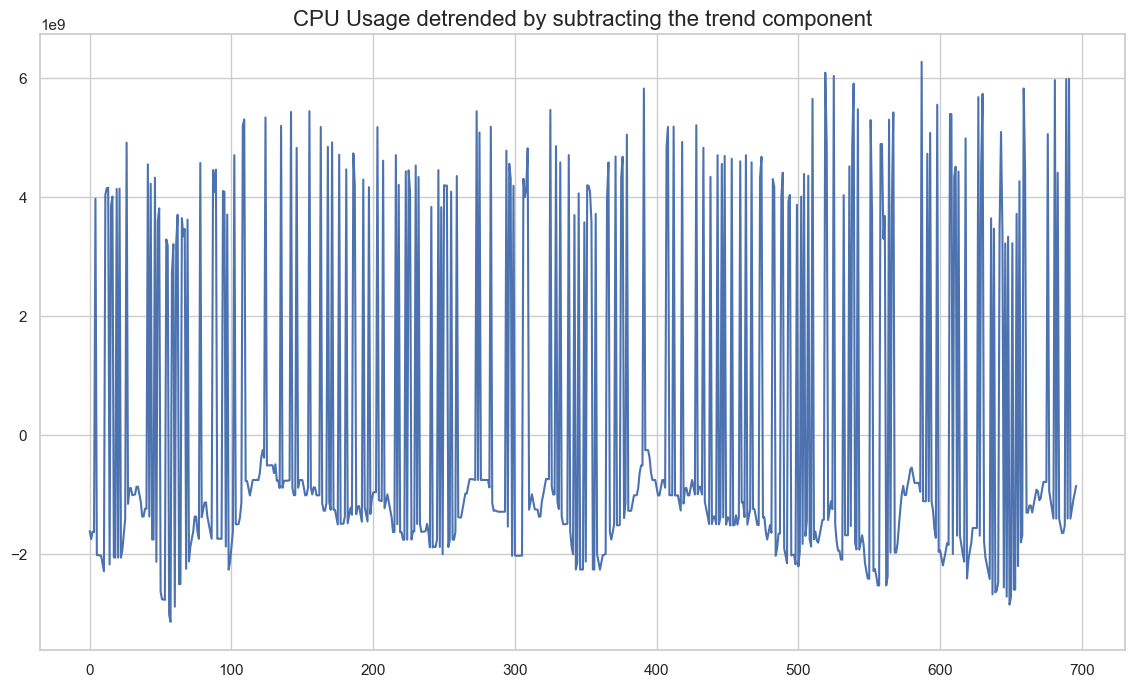

In [10]:
plt.plot(dt_df.values)
plt.title('CPU Usage detrended by subtracting the trend component', fontsize=16)

In [11]:
# let's check for the stationaity in the series using Augmented Dickey Fuller
# ADF Test
result = adfuller(df, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -26.104218950615135
p-value: 0.0


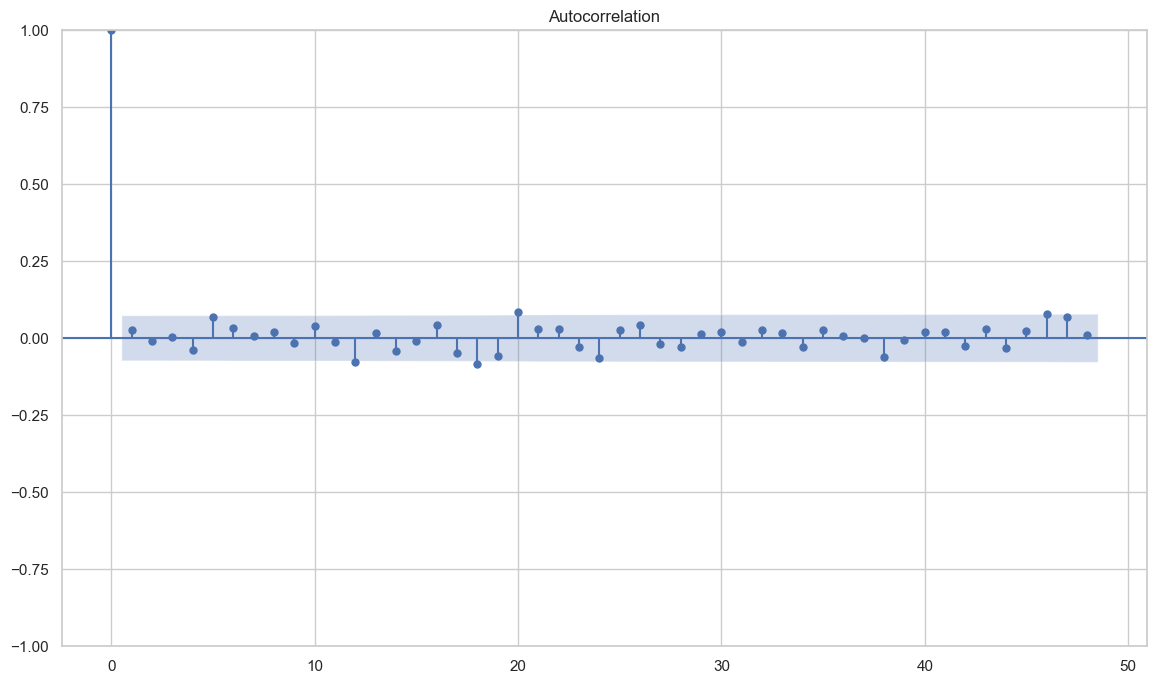

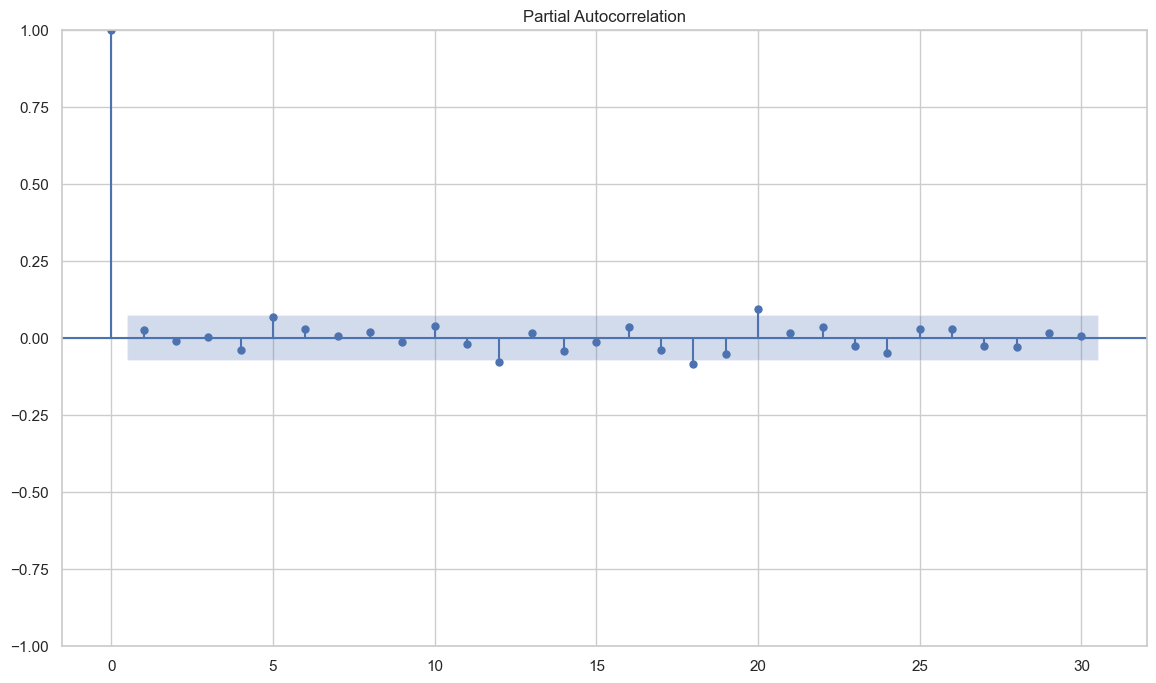

In [12]:
# Let’s look at ACF and PACF plots to get an idea for p and q values
plot_acf(df, lags=48);
plot_pacf(df, lags=30);

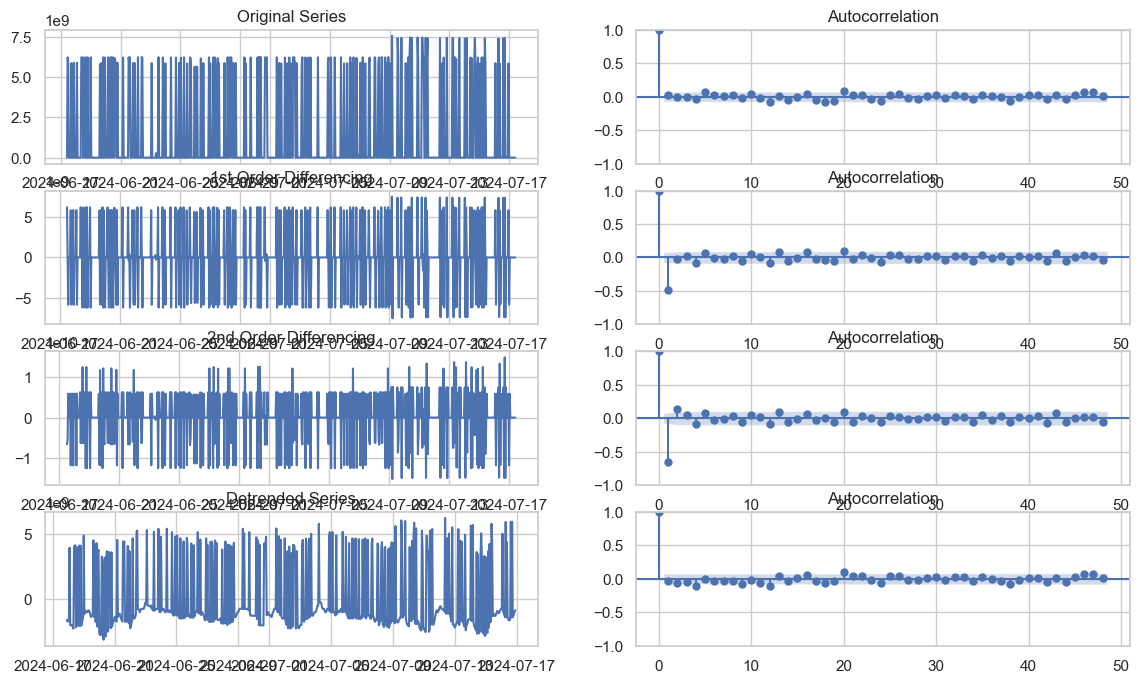

In [13]:
# Original Series
fig, axes = plt.subplots(4, 2)
axes[0, 0].plot(df); axes[0, 0].set_title('Original Series')
plot_acf(df, lags = 48, ax=axes[0, 1])

# 1st Differencing
df_1diff = df.diff()
df_1diff.dropna(inplace=True)
axes[1, 0].plot(df_1diff); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_1diff, lags = 48, ax=axes[1, 1])

# 2nd Differencing
df_2diff = df.diff().diff()
df_2diff.dropna(inplace=True)
axes[2, 0].plot(df_2diff); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_2diff, lags = 48, ax=axes[2, 1])

# Detrended Series
axes[3, 0].plot(dt_df); axes[3, 0].set_title('Detrended Series')
plot_acf(dt_df, lags = 48, ax=axes[3, 1])

plt.show()

In [14]:
# ADF Test
result = adfuller(df_1diff, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -10.356874682084214
p-value: 2.4535811516761773e-18
Critial Values:
   1%, -3.439739809554328
Critial Values:
   5%, -2.86568368980381
Critial Values:
   10%, -2.5689766074363334


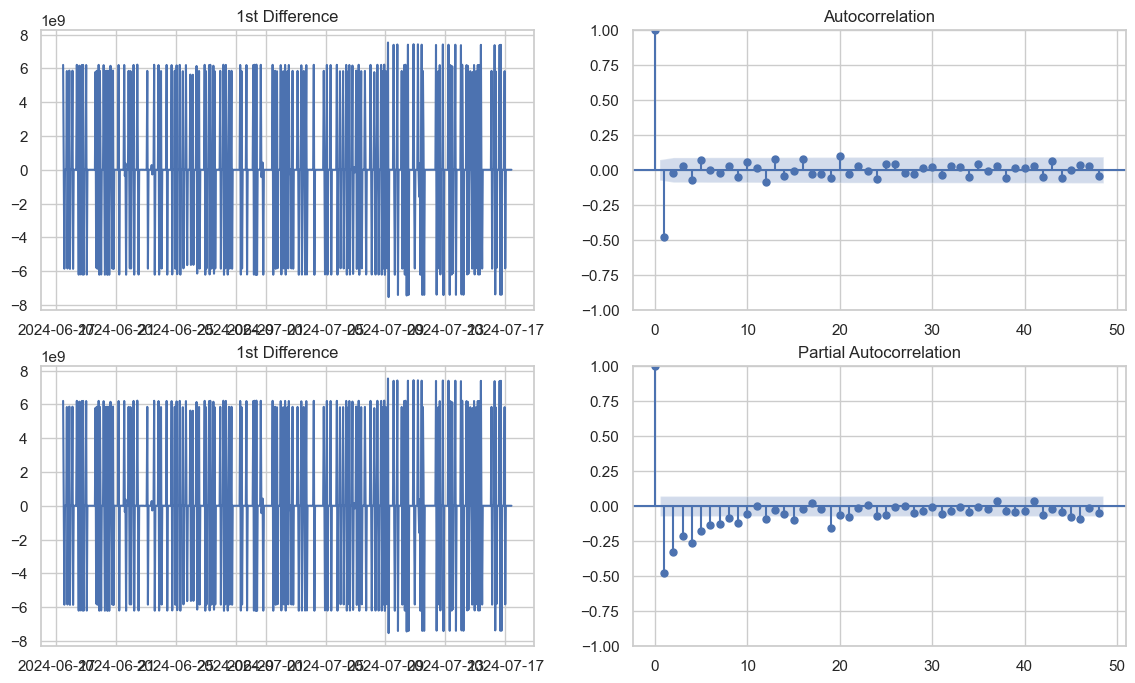

In [15]:
# Original Series
fig, axes = plt.subplots(2, 2)
axes[0, 0].plot(df_1diff); axes[0, 0].set_title('1st Difference')
plot_acf(df_1diff, lags = 48, ax=axes[0, 1])

axes[1, 0].plot(df_1diff); axes[1, 0].set_title('1st Difference')
plot_pacf(df_1diff, lags = 48, ax=axes[1, 1])

plt.show()

In [24]:
sarima = SARIMAX(df,
                order=(3,1,0),
                seasonal_order=(3,1,0,7))
predictions = sarima.fit().predict()

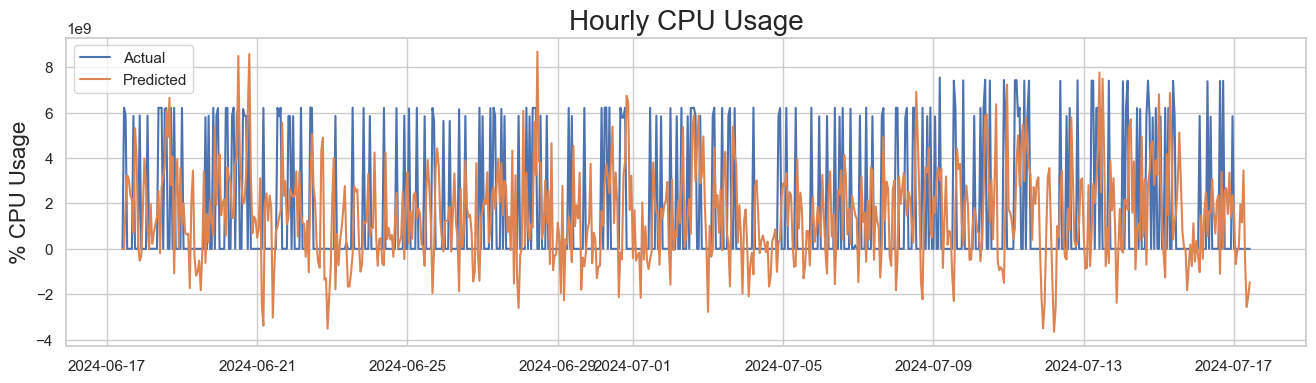

In [25]:
plt.figure(figsize=(16,4))
plt.plot(df, label="Actual")
plt.plot(predictions, label="Predicted")
plt.title('Hourly CPU Usage', fontsize=20)
plt.ylabel('% CPU Usage', fontsize=16)
plt.legend()

In [36]:
len(df)# Assuming df is your DataFrame with 721 rows
total_len = len(df)
split_ratio = 0.5 # Example ratio for splitting

# Calculate split indices
split_index = int(total_len * split_ratio)

# Split into training and test sets
train = df[:split_index]
test = df[split_index:]

# Verify lengths
print(f"Length of train set: {len(train)}")
print(f"Length of test set: {len(test)}")

Length of train set: 360
Length of test set: 361


In [37]:
# train = df[:2196]
# test = df[2196:]

In [38]:
len(train)
len(test)

361

In [45]:
sr_model = SARIMAX(train,
                order=(3,1,0),
                seasonal_order=(3,1,0,7))
sr_fit = sr_model.fit()
sr_fc = sr_fit.forecast(steps=361)

In [47]:
sr_rmse = np.sqrt(mean_squared_error(test,sr_fc))
print("SARIMAX RMSE -> {}".format(sr_rmse))

SARIMAX RMSE -> 3262184703.267968


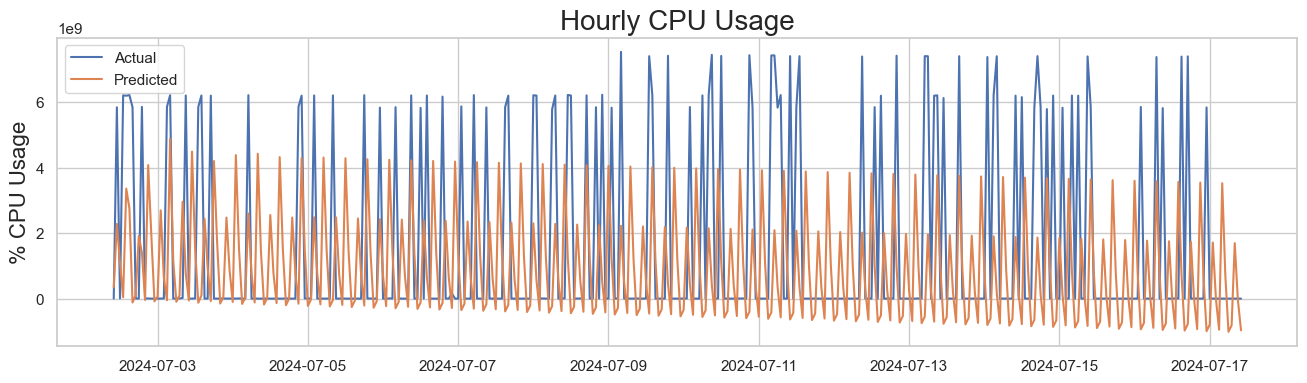

In [48]:
plt.figure(figsize=(16,4))
plt.plot(test, label="Actual")
plt.plot(sr_fc, label="Predicted")
plt.title('Hourly CPU Usage', fontsize=20)
plt.ylabel('% CPU Usage', fontsize=16)
plt.legend()